In [2]:
import pandas as pd

In [3]:
nvidia_df = pd.read_csv("../00_data/Sentiment_Only_Data_22MAR.gz", compression="gzip")

In [4]:
nvidia_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Index', 'videoID', 'datePub',
       'searchedDate', 'VideoTitle', 'channelTitle', 'viewCount', 'likeCount',
       'dislikeCount', 'captionString', 'videoTitleSentimentScore_pos',
       'videoTitleSentimentScore_neg', 'captionSentimentScore_pos',
       'captionSentimentScore_neg', 'captionSentimentScore_com',
       'videoTitleSentimentScore_com', 'num_days_since_pub',
       'viewcounts_weighted', 'like_count_weighted', 'dislike_count_weighted',
       'like_dislike_ratio', 'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted', 'Date'],
      dtype='object')

In [8]:
!pip install yfinance


  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=a6fe57b1192f6092b55c7c2f1de2f586b62a3cef652813f413aae72baf3a1191
  Stored in directory: /Users/dapoadegbile/Library/Caches/pip/wheels/b4/c3/39/9c01ae2b4726f37024bba5592bec868b47a2fab5a786e8979a
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=143e910ee54b1f27080e06d0bdecf2045e8f4d1fe611b12ff537f59c7ac1da66
  Stored in directory: /Users/dapoadegbile/Library/Caches/pip/wheels/57/6d/a3/a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking


In [9]:
# This is a function to generate response variable dataframe
# Decision rule:
# If the change in "High" in 5 days is greater than 3%, we give it label "buy"
# If the change in "High" in 5 days is smaller than -3%, we give it label "sell"
# Otherwise, we give it label "hold
def create_response(start_date, end_date, stock_name):
    import pandas as pd
    import numpy as np
    import yfinance as yf

    # get stock info
    data = (
        yf.download(stock_name, start=start_date, end=end_date)
        .asfreq("D")
        .fillna(method="ffill")
    )
    # create percentage dict
    percent_dict = {}
    for i in range(len(data) - 5):
        cur_high = data.iloc[i, :]["High"]
        future_high = data.iloc[i + 5, :]["High"]
        percent_dict[data.index[i]] = (future_high - cur_high) / cur_high
    response_df = pd.DataFrame.from_dict(
        percent_dict, orient="index", columns=["percent_change"]
    )
    # Decsion rule
    bins = [-(np.inf), -0.03, 0.03, np.inf]
    names = ["sell", "hold", "buy"]
    response_df["action"] = pd.cut(response_df["percent_change"], bins, labels=names)
    response_df = response_df.reset_index()
    return response_df

In [10]:
responce_df = create_response("2020-10-02", "2021-03-28", "NVDA")

[*********************100%***********************]  1 of 1 completed


### BY VIDEO DATA SET

In [11]:
X_feautures_pre_merge = nvidia_df.copy()

In [12]:
X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

In [13]:
X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_full_feautures_final = X_feautures_pre_merge.merge(
    responce_df, left_on="Date", right_on="index", how="left", indicator=True
)

In [14]:
X_full_feautures_final.tail()

,Unnamed: 0,Unnamed: 0.1,Index,videoID,datePub,searchedDate,VideoTitle,channelTitle,viewCount,likeCount,...,like_count_weighted,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,Date,index,percent_change,action,_merge
20788,20788,20788,20,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2021-03-19 18:03:20.670031+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3741789,148430,...,802.324324,22.789189,0.972381,0.972381,19667.258436,2021-03-19,NaN,NaN,NaN,left_only
20789,20789,20789,21,3dJhDqLjPN0,2021-02-24 21:59:34+00:00,2021-03-19 18:03:21.320922+00:00,NVIDIA (NVDA) Stock Analysis - Q4 Earnings + I...,The Investor Channel,7773,269,...,11.695652,0.043478,0.996296,0.996296,336.704831,2021-03-19,NaN,NaN,NaN,left_only
20790,20790,20790,22,H1DApIvOCMw,2021-02-26 17:35:37+00:00,2021-03-19 18:03:21.788746+00:00,My SALTY Review of the NVIDIA RTX 3060...,JayzTwoCents,1013948,51773,...,2353.318182,31.909091,0.986622,0.986622,45471.982159,2021-03-19,NaN,NaN,NaN,left_only
20791,20791,20791,23,Y5J2bgXiK9g,2021-03-09 17:00:10+00:00,2021-03-19 18:03:22.387116+00:00,Should Nvidia Stop Selling 3060s?,LMG Clips,53940,2238,...,203.454545,3.000000,0.985469,0.985469,4832.381410,2021-03-19,NaN,NaN,NaN,left_only
20792,20792,20792,24,HZigkcTxRo0,2021-02-25 03:01:00+00:00,2021-03-19 18:03:22.919039+00:00,Nvidia’s plan ISN’T WORKING,TechLinked,1394144,145393,...,6321.434783,176.217391,0.972880,0.972880,58971.068972,2021-03-19,NaN,NaN,NaN,left_only


### BY DAY

In [15]:
X_features = nvidia_df.filter(
    [
        "videoTitleSentimentScore_pos",
        "videoTitleSentimentScore_neg",
        "videoTitleSentimentScore_com",
        "captionSentimentScore_pos",
        "captionSentimentScore_neg",
        "captionSentimentScore_com",
        "num_days_since_pub",
        "viewcounts_weighted",
        "like_count_weighted",
        "like_dislike_ratio",
        "weighted_like_dislike_ratio",
        "like_dislike_ratio_by_viewcounts_weighted",
        "Date",
    ],
    axis=1,
)

X_feautures_pre_merge = X_features.groupby(["Date"]).mean().reset_index()

In [16]:
X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_feautures_pre_merge["Date"] = pd.to_datetime(
    X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
).dt.date

responce_df["index"] = pd.to_datetime(
    responce_df["index"], format="%Y-%m-%d", utc=True
).dt.date

X_agg_by_day_feautures_final = X_feautures_pre_merge.merge(
    responce_df, left_on="Date", right_on="index", how="left", indicator=True
)

In [17]:
X_agg_by_day_feautures_final.tail()

,Date,videoTitleSentimentScore_pos,videoTitleSentimentScore_neg,videoTitleSentimentScore_com,captionSentimentScore_pos,captionSentimentScore_neg,captionSentimentScore_com,num_days_since_pub,viewcounts_weighted,like_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,index,percent_change,action,_merge
113,2021-03-15,0.037338,0.033960,0.011886,0.087764,0.030724,0.687723,109.768889,15241.801392,1049.344298,0.955442,0.955442,14861.456219,2021-03-15,-0.021599,hold,both
114,2021-03-16,0.037245,0.064280,-0.023965,0.105100,0.034100,0.809068,108.970000,14870.723784,1032.050839,0.954523,0.954523,14469.862263,2021-03-16,-0.043737,sell,both
115,2021-03-17,0.038080,0.066406,-0.012098,0.102891,0.033063,0.799257,111.137143,14748.626569,939.470945,0.956001,0.956001,14378.400682,2021-03-17,-0.004367,hold,both
116,2021-03-18,0.051550,0.061970,0.012939,0.099855,0.031660,0.764304,107.740000,15558.251680,1049.395704,0.956913,0.956913,15162.712790,2021-03-18,0.012174,hold,both
117,2021-03-19,0.042326,0.062851,0.002587,0.109966,0.036794,0.835340,110.005714,15417.660309,1121.427479,0.957292,0.957292,15049.514412,NaN,NaN,NaN,left_only


In [18]:
X_agg_by_day_feautures_final.shape

(118, 17)

In [22]:
from plotnine import *

/Users/dapoadegbile/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/dapoadegbile/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


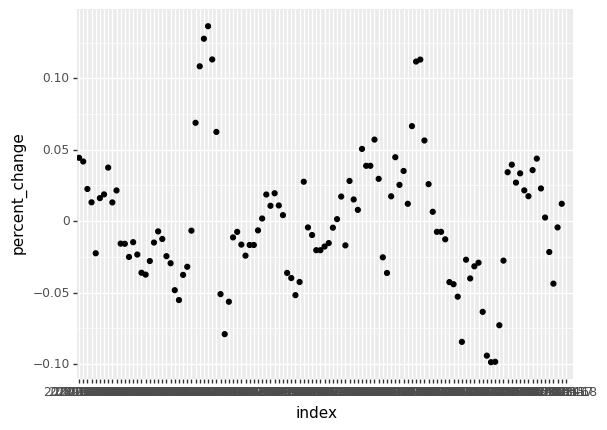

<ggplot: (8764753214983)>

In [89]:
ggplot(X_agg_by_day_feautures_final, aes(x='index', y='percent_change')) + geom_point() + geom_smooth(method = 'lowess')

/Users/dapoadegbile/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


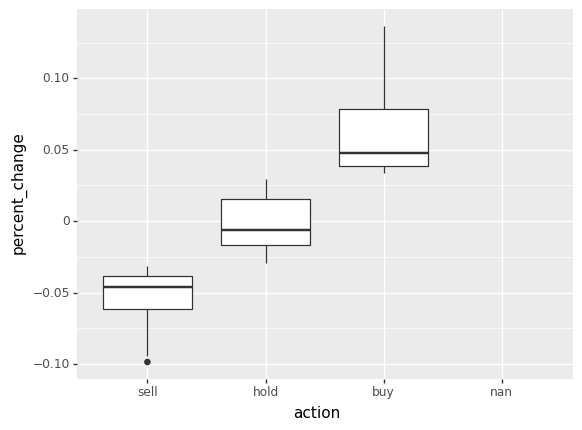

<ggplot: (8764759321640)>

In [95]:
ggplot(X_agg_by_day_feautures_final, aes(x='action' , y = 'percent_change')) + geom_boxplot()

In [72]:
import seaborn as sns 
import matplotlibas plt

In [83]:
X_agg_by_day_feautures_final.columns[3]

'videoTitleSentimentScore_com'

videoTitleSentimentScore_neg


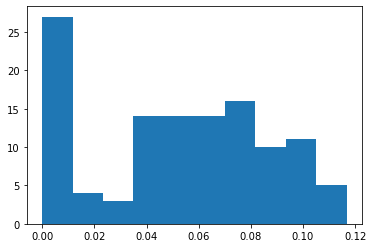

videoTitleSentimentScore_com


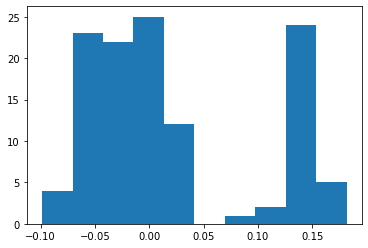

captionSentimentScore_pos


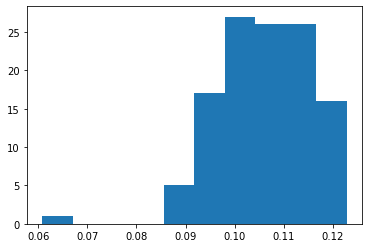

captionSentimentScore_neg


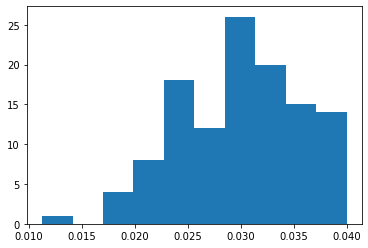

captionSentimentScore_com


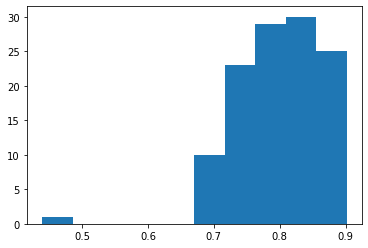

num_days_since_pub


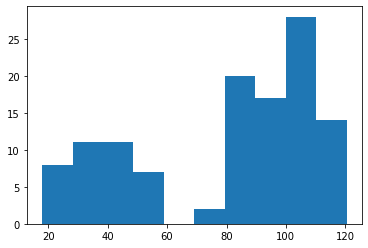

viewcounts_weighted


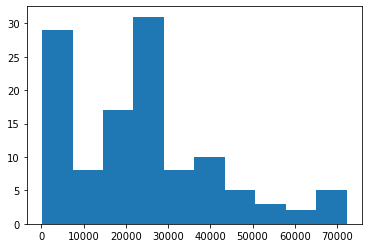

like_count_weighted


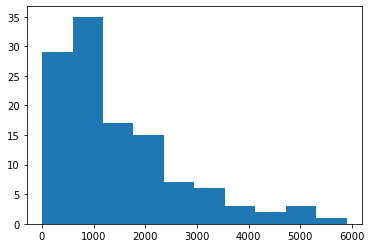

like_dislike_ratio


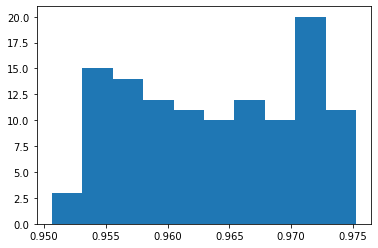

weighted_like_dislike_ratio


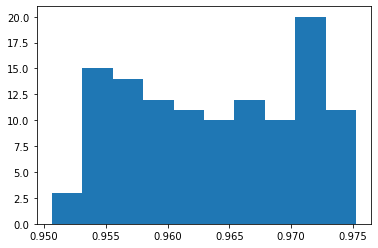

like_dislike_ratio_by_viewcounts_weighted


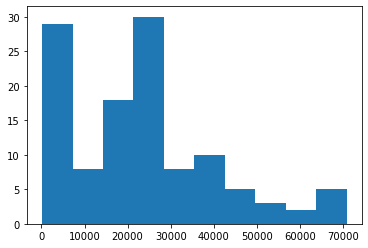

In [85]:
for i in range(2, 13):
#     plt.subplot(3, 4, i)
    plt.hist(X_agg_by_day_feautures_final.iloc[:, i])
    plt.xlabel = print(X_agg_by_day_feautures_final.columns[i])
    plt.show()
    